In [1]:
from datamaker_f import VideoDataGenerator, VideoDataGenerator2
from pipeline_f import build_full_model
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset from the pickle file
with open("F:/video_data_nt_16K.pkl", "rb") as f:
    pickled_data = pickle.load(f)


In [3]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frame_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000' structure:
Frames count: 25
Frames labels count: 25
Micro-expression count: 75
Micro-expression labels count: 75


In [4]:
video_names, labels = zip(*[
    (video_name, video_info['frame_label'][0])
    for video_name, video_info in pickled_data.items()
    if 'frame_label' in video_info and len(video_info['frame_label']) > 0
])


In [5]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [6]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [7]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

8940
2236
4791


In [8]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

In [9]:
import numpy as np

def count_classes_tf_dataset(dataset):
    counts = {}
    
    for batch_X, batch_y in dataset:
        # Convert batch_y to numpy for counting
        batch_y = batch_y.numpy()
        unique, counts_batch = np.unique(batch_y, return_counts=True)
        for u, c in zip(unique, counts_batch):
            counts[u] = counts.get(u, 0) + c
    
    return counts

# Example for train, val, and test datasets
train_counts = count_classes_tf_dataset(train_generator)
val_counts = count_classes_tf_dataset(val_generator)
test_counts = count_classes_tf_dataset(test_generator)

# Print the results
print("Training Data Distribution:", train_counts)
print("Validation Data Distribution:", val_counts)
print("Testing Data Distribution:", test_counts)


Training Data Distribution: {0.0: 4449, 1.0: 4491}
Validation Data Distribution: {0.0: 1106, 1.0: 1130}
Testing Data Distribution: {0.0: 2412, 1.0: 2379}


X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)
X_frames shape: (16, 224, 224, 3)
X_micro_exp shape: (16, 64, 64, 3)
y shape: (16, 1)


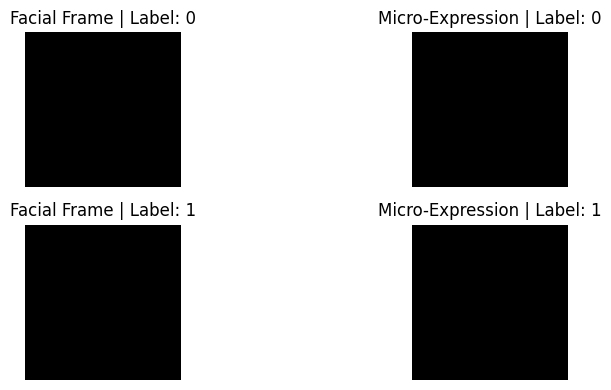

sample_frame_0 type: <class 'numpy.ndarray'>, dtype: uint8
sample_micro_exp_0 type: <class 'numpy.ndarray'>, dtype: uint8
sample_frame_0 shape: (224, 224, 3)
sample_micro_exp_0 shape: (64, 64, 3)
sample_frame_1 type: <class 'numpy.ndarray'>, dtype: uint8
sample_micro_exp_1 type: <class 'numpy.ndarray'>, dtype: uint8
sample_frame_1 shape: (224, 224, 3)
sample_micro_exp_1 shape: (64, 64, 3)


In [10]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Initialize placeholders for samples
sample_frame_0 = None
sample_micro_exp_0 = None
sample_frame_1 = None
sample_micro_exp_1 = None

# Take a batch and unpack it
for batch in train_generator.take(2):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy()
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy()

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy()
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy()

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Ensure the data is not None before processing
if sample_frame_0 is not None and sample_micro_exp_0 is not None:
    sample_frame_0 = sample_frame_0.astype("uint8")
    sample_micro_exp_0 = sample_micro_exp_0.astype("uint8")
else:
    print("Warning: Label 0 data not found in the batch.")

if sample_frame_1 is not None and sample_micro_exp_1 is not None:
    sample_frame_1 = sample_frame_1.astype("uint8")
    sample_micro_exp_1 = sample_micro_exp_1.astype("uint8")
else:
    print("Warning: Label 1 data not found in the batch.")

# Plot
plt.figure(figsize=(10, 4))

if sample_frame_0 is not None and sample_micro_exp_0 is not None:
    # Display facial and micro-expression frames for label 0
    plt.subplot(2, 2, 1)
    plt.imshow(sample_frame_0)
    plt.title("Facial Frame | Label: 0")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(sample_micro_exp_0)
    plt.title("Micro-Expression | Label: 0")
    plt.axis("off")

if sample_frame_1 is not None and sample_micro_exp_1 is not None:
    # Display facial and micro-expression frames for label 1
    plt.subplot(2, 2, 3)
    plt.imshow(sample_frame_1)
    plt.title("Facial Frame | Label: 1")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(sample_micro_exp_1)
    plt.title("Micro-Expression | Label: 1")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Print the final details
if sample_frame_0 is not None and sample_micro_exp_0 is not None:
    print(f"sample_frame_0 type: {type(sample_frame_0)}, dtype: {sample_frame_0.dtype}")
    print(f"sample_micro_exp_0 type: {type(sample_micro_exp_0)}, dtype: {sample_micro_exp_0.dtype}")
    print(f"sample_frame_0 shape: {sample_frame_0.shape}")
    print(f"sample_micro_exp_0 shape: {sample_micro_exp_0.shape}")

if sample_frame_1 is not None and sample_micro_exp_1 is not None:
    print(f"sample_frame_1 type: {type(sample_frame_1)}, dtype: {sample_frame_1.dtype}")
    print(f"sample_micro_exp_1 type: {type(sample_micro_exp_1)}, dtype: {sample_micro_exp_1.dtype}")
    print(f"sample_frame_1 shape: {sample_frame_1.shape}")
    print(f"sample_micro_exp_1 shape: {sample_micro_exp_1.shape}")


In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [12]:
optimizer = Adam(learning_rate=1e-4)

In [13]:
model = build_full_model()

In [14]:
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [15]:
model.summary()

Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 spatial_feature_extractor   (None, 2048)                 2358771   ['input_7[0][0]']             
 (Functional)                                             2                                       
                                                                                                  
 micro_exp_spatial_feature_  (None, 128)                  2224448   ['input_8[0][0]']    

In [ ]:
history_df = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/1000


    423/Unknown - 978s 2s/step - loss: 0.9175 - accuracy: 0.5121

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

300/300 [==============================] - 190s 633ms/step - loss: 0.6481 - accuracy: 0.7055
Test loss: 0.6481104493141174, Test accuracy: 0.705489456653595
